# Отток клиентов

**Оисание сути задачи** Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
1. Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
2. Построить модель с предельно большим значением *F1*-меры (довести метрику до 0.59). 
3. Проверить *F1*-меру на тестовой выборке.
4. Сравнить *AUC-ROC*,  со значением *F1*-мерой

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score

from sklearn.utils import shuffle 

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
pd.options.display.float_format = '{:,.2f}'.format
matplotlib.style.use('ggplot')
%matplotlib inline

## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

### Взгляд на данные

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


In [4]:
data.columns = data.columns.str.lower()

### Структура данных и  пропуски

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В стоблце Tenure(сколько лет человек является клиентом банка) выявлены пропуски. Есть стоблцы типа Gender с типом object

In [6]:
data[data['tenure'].isna()]

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,nan,0.00,3,1,0,"140,469.38",1
48,49,15766205,Yin,550,Germany,Male,38,nan,"103,391.38",1,0,1,"90,878.13",0
51,52,15768193,Trevisani,585,Germany,Male,36,nan,"146,050.97",2,0,0,"86,424.57",0
53,54,15702298,Parkhill,655,Germany,Male,41,nan,"125,561.97",1,0,0,"164,040.94",1
60,61,15651280,Hunter,742,Germany,Male,35,nan,"136,857.00",1,0,0,"84,509.57",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,nan,"190,409.34",2,1,1,"138,361.48",0
9956,9957,15707861,Nucci,520,France,Female,46,nan,"85,216.61",1,1,0,"117,369.52",1
9964,9965,15642785,Douglas,479,France,Male,34,nan,"117,593.48",2,0,0,"113,308.29",0
9985,9986,15586914,Nepean,659,France,Male,36,nan,"123,841.49",2,1,0,"96,833.00",0


Количество пропущенных значений в столбце около 10%. Характер пропусков в столбце tenure, в целом, говорит, что зависимостей пропусков от других характеристик не выявлено. Полагаю, лучше заменить NAN на медиану.

In [7]:
data['tenure'].fillna(value=data['tenure'].median(), inplace=True)

### Описательная статистика

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rownumber,"10,000.00","5,000.50","2,886.90",1.00,"2,500.75","5,000.50","7,500.25","10,000.00"
customerid,"10,000.00","15,690,940.57","71,936.19","15,565,701.00","15,628,528.25","15,690,738.00","15,753,233.75","15,815,690.00"
creditscore,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
tenure,"10,000.00",5.00,2.76,0.00,3.00,5.00,7.00,10.00
balance,"10,000.00","76,485.89","62,397.41",0.00,0.00,"97,198.54","127,644.24","250,898.09"
numofproducts,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
hascrcard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
isactivemember,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimatedsalary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"


- CreditScore - что - то в стиле FICO, возраст распределён равномерно
- Age - возраст в диапзоне 18-92, без аномальных выбросов
- Tenure -  от 0-10 лет, медиана  = среднему значению
- Balance - от 0-250, есть небольшое смещение в строну более высокого баланса
- NumOfProducts - от 1 до 4, в целом используют один продукт
- IsActiveMember - активен или нет клиент
- EstimatedSalary -  от 11 до ~200


**Вывод:** на первый взгляд аномалий и сильных выбросов не видно.

### Оценка целевого значения


In [9]:
data['exited'].value_counts(normalize=True).to_frame()

,exited
0,0.80
1,0.20


**Вывод:** Отток клиентов отмечен на 20% выборки. В нашей задаче наблюдается сильный дисбаланс классов. Классы несбалансированны, когда их соотношение далеко от 1:1. Баланс классов наблюдается, если их количество примерно равно. В нашем случае соотношение 4:1, что  плохо сказывается на обучении модели. 

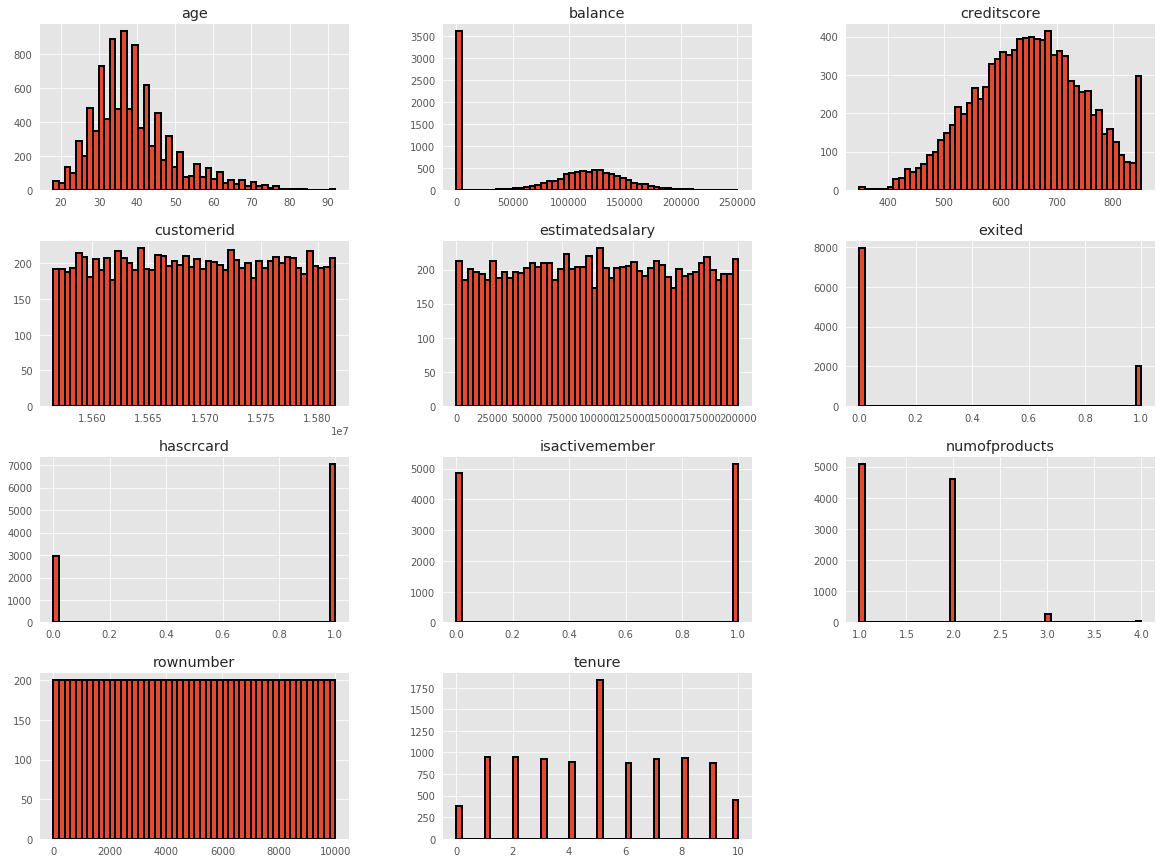

In [10]:
data.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2);

**Вывод:** Отток клиентов достаточно важный показатель для любой коммерческой организации, так как на привлечение новых, обычно требуется больше ресурсов, как денежных, так и трудовых. В процессе исследования данных дубликатов не выявлено, нет необходимости удалять строки плюс не выявлено каких-либо аномальных отклонений, то есть те данные, которые были бы оторваны от реальности. В стоблце Tenure(сколько лет человек является клиентом банка) выявлены пропуски заменили на медиану.

## Исследование задачи

Перед нами стоит задача классификации - необходимо определить, уйдет клиент в ближайшее время или нет. Для достижения целей этой задачи предлагаю использовать алгоритмы Логистической регрессии и Случайного леса. 
- Для оценки моделей мы будем использовать показатель F1, как поставлено по условию задачи (метрика значения должна быть ~ 0,59)
- Для оценки окончательной модели мы используем кривую ROC с ее площадью (ROC-AUC).
- Как мы выяснили, у нас дисбаланс классов, точность нам не подходит.


Удалим признаки, которые не несут смысловой нагрузки 

In [11]:
data.drop(['rownumber', 'customerid', 'surname'], axis=1, inplace = True)

In [12]:
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


Посмотрим линейные корреляции, нас интересуют зависимости с Exited

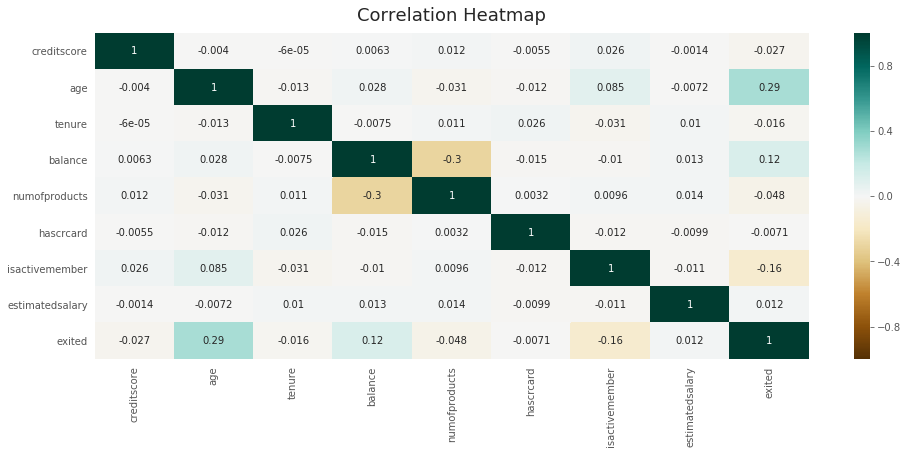

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12); 

### Кодирование категориальных признаков

Как мы видим есть категориальные признаки в столбцах geography и gender. Принадлежность к категории логистическая регрессия вычисляет по формуле, состоящей из признаков. Они могут быть только численные. Поэтому применим технику прямого кодирования  One-Hot Encoding путем создания фиктивных переменных, используем функцию **pd.get_dummies()**

In [14]:
data['geography'].unique(), data['gender'].unique()

(array(['France', 'Spain', 'Germany'], dtype=object),
 array(['Female', 'Male'], dtype=object))

In [15]:
gender_ohe = pd.get_dummies(data['geography'])
geography_ohe = pd.get_dummies(data['gender'])
data_ohe = pd.concat([data, gender_ohe, geography_ohe], axis=1)
data_ohe.drop(['geography','gender'],axis=1, inplace = True)
data_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,France,Germany,Spain,Female,Male
0,619,42,2.00,0.00,1,1,1,"101,348.88",1,1,0,0,1,0
1,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,0,1,1,0
2,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,1,0,0,1,0
3,699,39,1.00,0.00,2,0,0,"93,826.63",0,1,0,0,1,0
4,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,0,1,1,0


Столбцы кодированы, drop_first=True не делали из собственных соображений.

### Деление выборок на  тренеровочную, проверочную, тестовую

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении (60/20/20)

In [16]:
from sklearn.model_selection import train_test_split # импорт библиотеки для сплита
data_train, data_valid_and_test = train_test_split(data_ohe, test_size=0.40, random_state=393) # Разобьём выборку на тренировочную и валидационную + тестовую
data_test, data_valid = train_test_split(data_valid_and_test, test_size=0.50, random_state=393)# Разобьём выборку на валидационную и тестовую

In [17]:
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(6000, 14)
(2000, 14)
(2000, 14)


In [18]:
features_train = data_train.drop(['exited'], axis=1)
target_train = data_train['exited'] 
features_valid = data_valid.drop(['exited'], axis=1)
target_valid = data_valid['exited']
features_test = data_test.drop(['exited'], axis=1)
target_test = data_test['exited']

Выборка была разделена. Как ранее упоминалось, что в  нашей задаче наблюдается сильный дисбаланс классов, что плохо сказывается на обучении модели. Перед тем как  присутпить к обучению моделей промасштабируем наш дата сет, то есть проведем стандартизацию данных

### Масштабирование

In [19]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain,Female,Male
89,635,28,3.00,"81,623.67",2,1,1,"156,791.36",0,1,0,1,0
4900,735,41,7.00,"179,904.00",1,1,1,"137,180.95",1,0,0,0,1
2061,445,38,6.00,"119,413.62",2,1,0,"175,756.36",0,1,0,1,0
6269,652,36,1.00,0.00,2,1,1,"19,302.78",0,0,1,1,0
1133,559,34,4.00,0.00,2,1,1,"66,721.98",1,0,0,0,1


In [20]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain,Female,Male
89,-0.17,-1.04,3.00,0.08,2,1,1,0.98,0,1,0,1,0
4900,0.87,0.20,7.00,1.66,1,1,1,0.63,1,0,0,0,1
2061,-2.14,-0.09,6.00,0.69,2,1,0,1.31,0,1,0,1,0
6269,0.01,-0.28,1.00,-1.23,2,1,1,-1.42,0,0,1,1,0
1133,-0.96,-0.47,4.00,-1.23,2,1,1,-0.59,1,0,0,0,1


Данные масштабированы

### Обучение моделей методами логистическая регрессия и случайный лес

Давайте посмотрим на результаты. Оценивать модель будем по показателю F1 - это метрика для оценки качества классификатора. Гиперпараметры подберем позже.

#### Используем базовую **логистическую регрессию**

In [21]:
model = LogisticRegression(random_state=393, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.2729044834307992


Достаточно плохой показатель

Придадим объектам редкого класса больший вес, добавим class_weight='balanced'

In [22]:
model = LogisticRegression(random_state=393, solver='liblinear',class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.47058823529411764


Получше

#### Используем базовую **Случайный лес**

In [23]:
model = RandomForestClassifier(random_state=393, n_estimators=10)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.49655172413793097


Случайный лес показывает лучший показатель

добавим class_weight='balanced'

In [24]:
model = RandomForestClassifier(random_state=393, n_estimators=10, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4735945485519591


результат хуже

Text(69.0, 0.5, 'Truth')

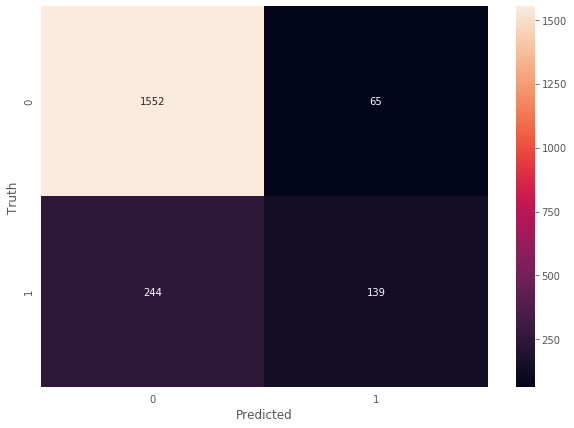

In [25]:
from sklearn import metrics
cm = metrics.confusion_matrix(target_valid,predicted_valid)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d');
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Вывод:** Чтобы улучшить результаты прогнозирования и облегчить обучение модели, мы преобразовали данные:

1. Удалены ненужные столбцы - такие как фамилия, идентификатор клиента и номер строки
2. Выполнено кодирование категориальных переменных
3. Выполнено масштабирование количественных переменных,
4. Разделены выборки в соотношении 60%: 20%:20% 
5. Попытались обучить модели на объектах с классовым дисбалансом
6. Посторили матрицу  ошибок

#### Подбор гиперпараметров RandomForestClassifier 

In [26]:
%%time
best_model = None
best_result = 0
class_weight_list = [None,'balanced']
for est in range(1, 30,2):
    for depth in range (1,30,2):
        for weight in class_weight_list:
            model_rfc_p= RandomForestClassifier(random_state=393, n_estimators=est, max_depth=depth, class_weight = weight) # обучим модель с заданным количеством деревьев n_estimators =30
            model_rfc_p.fit(features_train,target_train) # обучим модель на train  выборке
            predicted_valid = model_rfc_p.predict(features_valid)
            result = f1_score(target_valid,predicted_valid) # качество модели на валидационной выборке
            if result > best_result:
                best_model = model # сохраним наилучшую модель
                best_result = result #  сохраним наилучшее значение метрики на валидационных данных
                best_depth = depth #  сохраним наилучшее значение метрики глубины дерева на валидационных данных
                best_est = est #  сохраним наилучшее значение метрики количество деревьев на валидационных данных
                best_class_weight = weight # сохраним наилучшее значение метрики вес на валидационных данных
print()
print("F1 - лучшей модели: {:.2%}: Глубина дерева-{}: Количество деревьев-{}: Баланс весов - {}:".format(best_result,best_depth,best_est,best_class_weight))
print()


F1 - лучшей модели: 58.39%: Глубина дерева-9: Количество деревьев-29: Баланс весов - balanced:

CPU times: user 55.8 s, sys: 138 ms, total: 55.9 s
Wall time: 56.2 s


## Борьба с дисбалансом

Перед нами по прежнему стоит задача классификации. Попробуем избавиться от проблемы классового дисбаланса, плюс выбирем гиперпараметры модели.

In [27]:
data['exited'].value_counts().to_frame()

,exited
0,7963
1,2037


Попробуем решить задачу дисбаланса тремя  способами и выбрать лучший.
- Увеличение выборки(Upsampling)
- Уменьшение выборки(Downsampling)
- Изменение порога(Change threshold)

### **Увеличение выборки (Upsampling)** <br>
Для этого давайте воспользуемся функцией Upsampling, выполним следующие преобразования:

- разделим обучающую выборку на отрицательные и положительные объекты
- скопируем положительные объекты несколько раз 
- учетом полученных данных создадим новую обучающую выборку
- перетасуем данные

In [28]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=393)
    target_upsampled = shuffle(target_upsampled, random_state=393)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10932, 13)
(10932,)


**LogisticRegression**

In [29]:
model = LogisticRegression(random_state=393, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46529968454258674


In [30]:
for repeat in range(1,10): 
    model = LogisticRegression(random_state=393, solver='liblinear')
    model.fit(features_upsampled, target_upsampled)
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    predicted_valid = model.predict(features_valid)
    print("F1:", f1_score(target_valid, predicted_valid),repeat)

F1: 0.46529968454258674 1
F1: 0.2729044834307992 2
F1: 0.44743935309973043 3
F1: 0.46186895810955964 4
F1: 0.4629133154602323 5
F1: 0.46529968454258674 6
F1: 0.4406779661016949 7
F1: 0.42400521852576645 8
F1: 0.41883519206939274 9


Для логистической регресии upsampling пошел на пользу, но не достаточно для выполнения задачи

**RandomForestClassifier**

In [31]:
model = RandomForestClassifier(random_state=393, n_estimators=10)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5225225225225226


In [32]:
for repeat in range(1,10): 
    model = RandomForestClassifier(random_state=393, n_estimators=10)
   
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print("F1:", f1_score(target_valid, predicted_valid),repeat)

F1: 0.49081803005008345 1
F1: 0.522273425499232 2
F1: 0.5465465465465466 3
F1: 0.5110782865583456 4
F1: 0.5499276410998554 5
F1: 0.5244444444444445 6
F1: 0.5289747399702823 7
F1: 0.521870286576169 8
F1: 0.5225225225225226 9


Есть небольшие  улучшения по сравнению с базовой моделью случайный лес.

### Уменьшение выборки (Downsampling)

Вместо повторения важных вопросов, уберём часть неважных. 

Преобразование проведем в несколько этапов:
- Разделим обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросим часть из отрицательных объектов;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=fraction, random_state=42)
    target_sample = target_zeros.sample(frac=fraction, random_state=42)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=42)
    target_downsampled = shuffle(target_downsampled, random_state=42)
    

    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

print(features_downsampled.shape)
print(target_downsampled.shape)

(3140, 13)
(3140,)


**LogisticRegression**

In [36]:
model = LogisticRegression(random_state=393, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.45323741007194246


In [37]:
for frac in np.arange(0.05,1,0.05): 
    model = LogisticRegression(random_state=393, solver='liblinear')
    model.fit(features_downsampled, target_downsampled)
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
    predicted_valid = model.predict(features_valid)
    print("F1:", f1_score(target_valid, predicted_valid),round(frac,2))\
    

F1: 0.45323741007194246 0.05
F1: 0.34594095940959413 0.1
F1: 0.39662921348314606 0.15
F1: 0.4318936877076412 0.2
F1: 0.453125 0.25
F1: 0.45933869526362825 0.3
F1: 0.45697329376854595 0.35
F1: 0.45625692137320045 0.4
F1: 0.45323741007194246 0.45
F1: 0.4520202020202021 0.5
F1: 0.4429530201342282 0.55
F1: 0.4438122332859175 0.6
F1: 0.42278860569715143 0.65
F1: 0.40186915887850466 0.7
F1: 0.36065573770491804 0.75
F1: 0.3531409168081494 0.8
F1: 0.34256055363321797 0.85
F1: 0.32374100719424465 0.9
F1: 0.30996309963099633 0.95


**RandomForestClassifier**

In [38]:
best_result = 0
for frac in np.arange(0.05,1,0.05):
    model = RandomForestClassifier(random_state=393, n_estimators=10)
    model.fit(features_downsampled, target_downsampled)
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print("F1:", f1_score(target_valid, predicted_valid),round(frac,2))
    if result> best_result:
#         best_model = model
        best_result = result
        best_frac = frac
print ("Лучший F1:",best_result, best_frac)

F1: 0.5123966942148761 0.05
F1: 0.38225629791894855 0.1
F1: 0.4391891891891892 0.15
F1: 0.4883333333333333 0.2
F1: 0.5075471698113208 0.25
F1: 0.513347022587269 0.3
F1: 0.5489313835770528 0.35
F1: 0.5400238948626045 0.4
F1: 0.5145018915510718 0.45
F1: 0.5468354430379746 0.5
F1: 0.5305039787798409 0.55
F1: 0.5491803278688523 0.6
F1: 0.5611111111111111 0.65
F1: 0.5319465081723626 0.7
F1: 0.5495495495495496 0.75
F1: 0.5125 0.8
F1: 0.5325077399380804 0.85
F1: 0.5307443365695792 0.9
F1: 0.5065359477124184 0.95
Лучший F1: 0.5611111111111111 0.6500000000000001


**Комментарий:** Лучше, но не совсем, что требовалось

### Изменение порога 

Изменим значение порога и посмотрим, какими станут метрики.

In [39]:
model = LogisticRegression(random_state=393, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

Threshold = 0.00 | Precision = 0.192, Recall = 1.000 | F1-score = 0.321
Threshold = 0.05 | Precision = 0.215, Recall = 0.982 | F1-score = 0.353
Threshold = 0.10 | Precision = 0.256, Recall = 0.901 | F1-score = 0.399
Threshold = 0.15 | Precision = 0.302, Recall = 0.799 | F1-score = 0.438
Threshold = 0.20 | Precision = 0.345, Recall = 0.679 | F1-score = 0.457
Threshold = 0.25 | Precision = 0.389, Recall = 0.569 | F1-score = 0.462
Threshold = 0.30 | Precision = 0.418, Recall = 0.467 | F1-score = 0.441
Threshold = 0.35 | Precision = 0.477, Recall = 0.405 | F1-score = 0.438
Threshold = 0.40 | Precision = 0.498, Recall = 0.319 | F1-score = 0.389
Threshold = 0.45 | Precision = 0.519, Recall = 0.251 | F1-score = 0.338
Threshold = 0.50 | Precision = 0.538, Recall = 0.183 | F1-score = 0.273
Threshold = 0.55 | Precision = 0.582, Recall = 0.138 | F1-score = 0.224
Threshold = 0.60 | Precision = 0.574, Recall = 0.102 | F1-score = 0.173
Threshold = 0.65 | Precision = 0.596, Recall = 0.073 | F1-score 

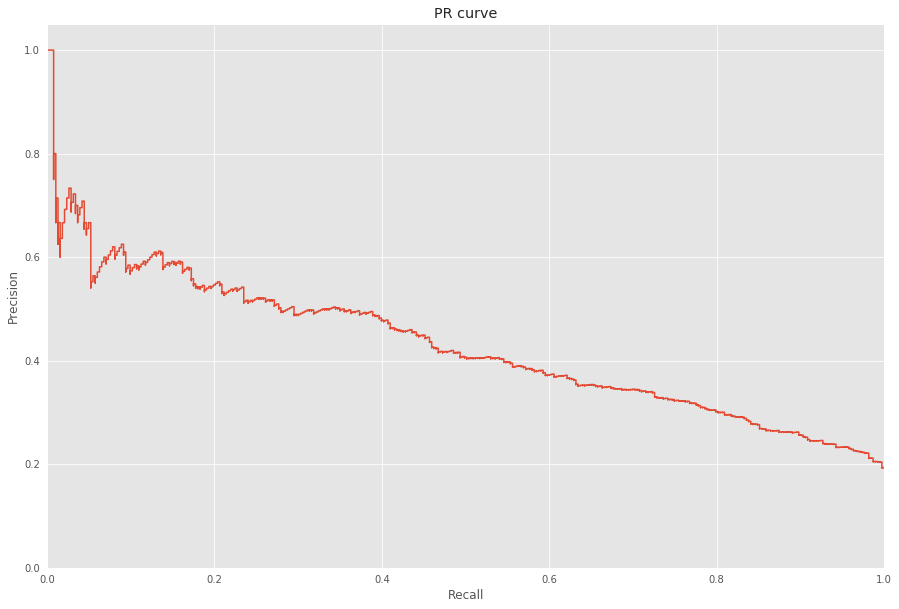

In [40]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(15, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

Для порога 0 полнота равна 1 - все ответы положительные. При пороговом значении 0,85 модель перестает давать правильные ответы. Самое высокое значение F1 наблюдается при пороге 0,25

In [41]:
model = RandomForestClassifier(random_state=393, n_estimators=10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.4f}".format(
        threshold, precision, recall, f1))

Threshold = 0.00 | Precision = 0.267, Recall = 0.903 | F1-score = 0.4119
Threshold = 0.05 | Precision = 0.267, Recall = 0.903 | F1-score = 0.4119
Threshold = 0.10 | Precision = 0.342, Recall = 0.760 | F1-score = 0.4716
Threshold = 0.15 | Precision = 0.342, Recall = 0.760 | F1-score = 0.4716
Threshold = 0.20 | Precision = 0.435, Recall = 0.650 | F1-score = 0.5209
Threshold = 0.25 | Precision = 0.435, Recall = 0.650 | F1-score = 0.5209
Threshold = 0.30 | Precision = 0.524, Recall = 0.569 | F1-score = 0.5457
Threshold = 0.35 | Precision = 0.524, Recall = 0.569 | F1-score = 0.5457
Threshold = 0.40 | Precision = 0.614, Recall = 0.478 | F1-score = 0.5374
Threshold = 0.45 | Precision = 0.614, Recall = 0.478 | F1-score = 0.5374
Threshold = 0.50 | Precision = 0.731, Recall = 0.376 | F1-score = 0.4966
Threshold = 0.55 | Precision = 0.731, Recall = 0.376 | F1-score = 0.4966
Threshold = 0.60 | Precision = 0.815, Recall = 0.311 | F1-score = 0.4499
Threshold = 0.65 | Precision = 0.815, Recall = 0.31

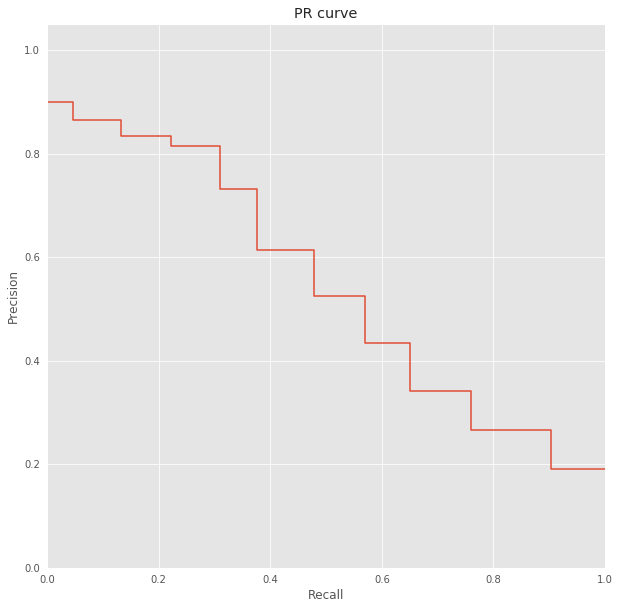

In [42]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

**Вывод:** Лучший показатель на границе 0,3, F1 = 0.52

### Настройка гиперпараметров

Для подбора гиперпараметров будем использовать GridSearchCV

**LogisticRegression**

In [43]:
%%time
best_model = None
best_result = 0
class_weight = [None,'balanced']
penalty_list = ['l1','l2']
inverse_regularization_strength=0

for inverse_regularization_strength in range (1,10):
    for weight in class_weight:
        for penalty in penalty_list:
            model_lreg = LogisticRegression(C=inverse_regularization_strength, penalty = penalty, class_weight=weight, solver='liblinear', random_state=393)
            model_lreg.fit(features_upsampled,target_upsampled) # обучим модель на upsampled тренировочной выборке
            predicted_valid = model_lreg.predict(features_valid)
            result = f1_score(target_valid,predicted_valid) #    
            if result > best_result:
                best_model = model # сохраним наилучшую модель
                best_result = result #  сохраним наилучшее значение метрики 
                best_class_weight = weight #  сохраним наилучшее значение метрики 
                best_c = inverse_regularization_strength
                best_penalty = penalty#  
print()
print("F1 - лучшей модели: {:.2%}: inverse_regularization_strength-{}: penalty-{}: class_weight - {}". format(best_result,best_c,best_penalty,best_class_weight))
print()


F1 - лучшей модели: 47.06%: inverse_regularization_strength-1: penalty-l1: class_weight - balanced

CPU times: user 26.3 s, sys: 2.8 s, total: 29.1 s
Wall time: 29.2 s


In [44]:
%%time
best_model = None
best_result = 0
class_weight = [None,'balanced']
penalty_list = ['l1','l2']
inverse_regularization_strength=0

for inverse_regularization_strength in range (1,10):
    for weight in class_weight:
        for penalty in penalty_list:
            model_lreg = LogisticRegression(C=inverse_regularization_strength, penalty = penalty, class_weight=weight, solver='liblinear', random_state=393)
            model_lreg.fit(features_downsampled,target_downsampled) # обучим модель на downsampled тренировочной выборке
            predicted_valid = model_lreg.predict(features_valid)
            result = f1_score(target_valid,predicted_valid) #    
            if result > best_result:
                best_model = model # сохраним наилучшую модель
                best_result = result #  сохраним наилучшее значение метрики 
                best_class_weight = weight #  сохраним наилучшее значение метрики 
                best_c = inverse_regularization_strength
                best_penalty = penalty#  
print()
print("F1 - лучшей модели: {:.2%}: inverse_regularization_strength-{}: penalty-{}: class_weight - {}". format(best_result,best_c,best_penalty,best_class_weight))
print()


F1 - лучшей модели: 47.07%: inverse_regularization_strength-2: penalty-l1: class_weight - balanced

CPU times: user 10.2 s, sys: 2.87 s, total: 13.1 s
Wall time: 13.4 s


**Комментарий:** Значительные улучшения, но недостаточные для требования задачи

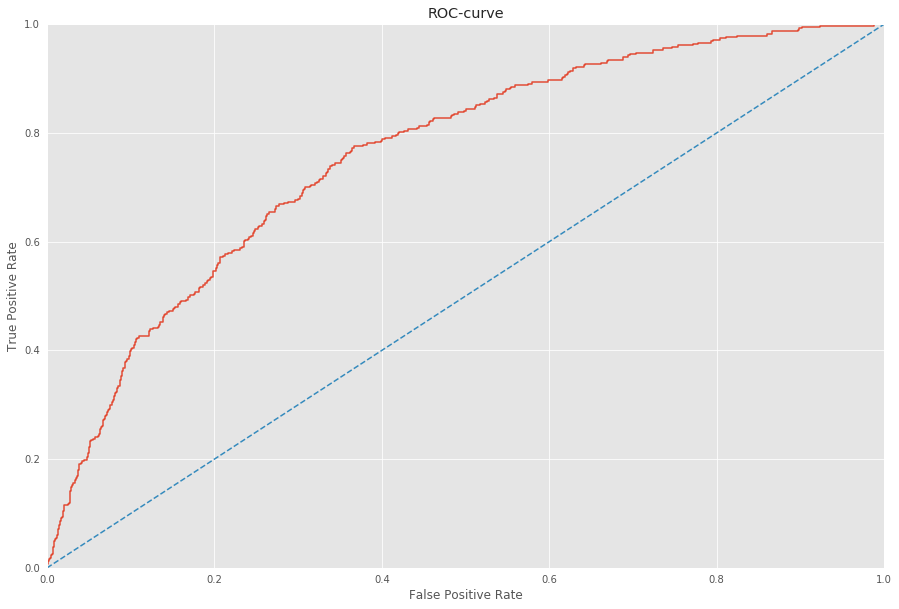

AUC: 0.7594520362144384


In [45]:
model_lreg = LogisticRegression(C=1, class_weight='balanced', intercept_scaling=1,penalty='l1',solver='liblinear', random_state=393)
model_lreg.fit(features_upsampled, target_upsampled)
probabilities_valid = model_lreg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

**Комментарий:** В целом, неплохо. AUC > 0.5 наша модель лучше чем случайная

**RandomForestClassifier**

In [46]:
%%time
best_model = None
best_result = 0
class_weight_list = [None,'balanced']
for est in range(1, 30,2):
    for depth in range (1,30,2):
        for weight in class_weight_list:
            model_rfc_upsampled= RandomForestClassifier(random_state=393, n_estimators=est, max_depth=depth, class_weight = weight) # обучим модель с заданным количеством деревьев n_estimators =30
            model_rfc_upsampled.fit(features_upsampled,target_upsampled) # обучим модель на upsampled тренировочной выборке
            predicted_valid = model_rfc_upsampled.predict(features_valid)
            result = f1_score(target_valid,predicted_valid) # качество модели на валидационной выборке
            if result > best_result:
                best_model = model # сохраним наилучшую модель
                best_result = result #  сохраним наилучшее значение метрики accuracy на валидационных данных
                best_depth = depth #  сохраним наилучшее значение метрики глубины дерева на валидационных данных
                best_est = est
                best_class_weight = weight#  сохраним наилучшее значение метрики количество деревьев на валидационных данных
print()
print("F1 - лучшей модели: {:.2%}: Глубина дерева-{}: Количество деревьев-{}: Баланс весов - {}:".format(best_result,best_depth,best_est,best_class_weight))
print()


F1 - лучшей модели: 58.98%: Глубина дерева-9: Количество деревьев-29: Баланс весов - balanced:

CPU times: user 1min 52s, sys: 105 ms, total: 1min 52s
Wall time: 1min 53s


**Вывод:** Well done, мы достигли требования задания.

In [47]:
%%time
best_model = None
best_result = 0
class_weight_list = [None,'balanced']
for est in range(1, 30,2):
    for depth in range (1,30,2):
        for weight in class_weight_list:
            model_rfc_downsampled= RandomForestClassifier(random_state=393, n_estimators=est, max_depth=depth, class_weight = weight) # обучим модель с заданным количеством деревьев n_estimators =30
            model_rfc_downsampled.fit(features_downsampled,target_downsampled) # обучим модель на тренировочной выборке
            predicted_valid = model_rfc_downsampled.predict(features_valid)
            result = f1_score(target_valid,predicted_valid) # посчитайте качество модели на валидационной выборке
            if result > best_result:
                best_model = model # сохраним наилучшую модель
                best_result = result #  сохраним наилучшее значение метрики accuracy на валидационных данных
                best_depth = depth #  сохраним наилучшее значение метрики глубины дерева на валидационных данных
                best_est = est
                best_class_weight = weight#  сохраним наилучшее значение метрики количество деревьев на валидационных данных
print()
print("F1 - лучшей модели: {:.2%}: Глубина дерева-{}: Количество деревьев-{}: Баланс весов - {}:".format(best_result,best_depth,best_est,best_class_weight))
print()


F1 - лучшей модели: 57.75%: Глубина дерева-9: Количество деревьев-29: Баланс весов - balanced:

CPU times: user 54.2 s, sys: 115 ms, total: 54.3 s
Wall time: 54.8 s


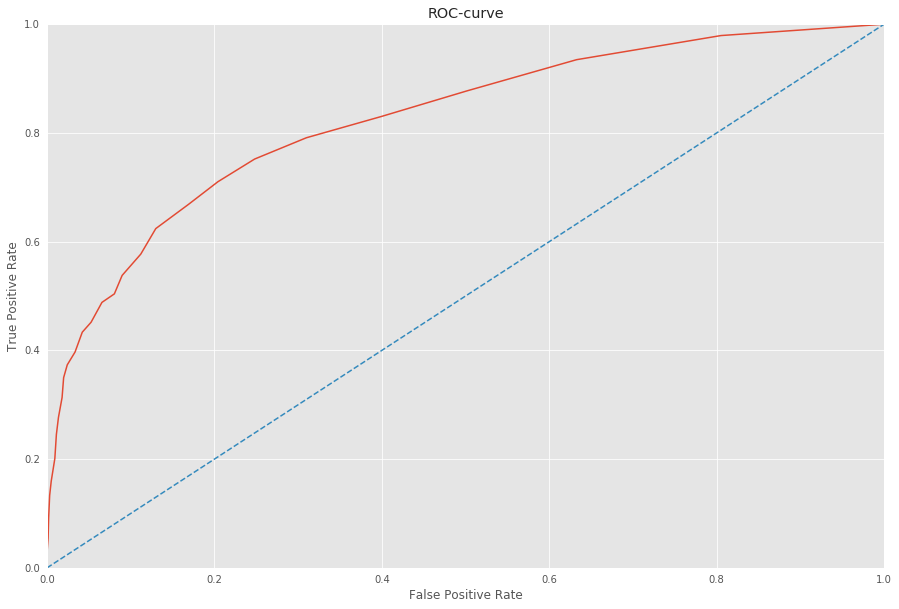

AUC: 0.8248747398318453


In [48]:
model_rfc = RandomForestClassifier(random_state=393, n_estimators=17, max_depth=9, class_weight = 'balanced')
model_rfc.fit(features_upsampled, target_upsampled)
probabilities_valid = model_rfc_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

**Вывод:** Модель RandomForestClassifier имеет соответствующий критерий качества F1 > 59%, и неплохой AUC 0.82

## Тестирование модели

In [49]:
table_of_model = []
table_of_prec = []
table_of_acc = []

In [50]:
predictions_test = model_lreg.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('LogisticRegression')

Accuracy
Тестовая выборка: 0.7155
F1-мера
Тестовая выборка: 0.5056472632493484


In [51]:
predictions_test = model_rfc.predict(features_test)
test_f1 = f1_score(target_test, predictions_test)
test_acc = accuracy_score(target_test, predictions_test)

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)

table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('RandomForestClassifier')

Accuracy
Тестовая выборка: 0.805
F1-мера
Тестовая выборка: 0.6020408163265306


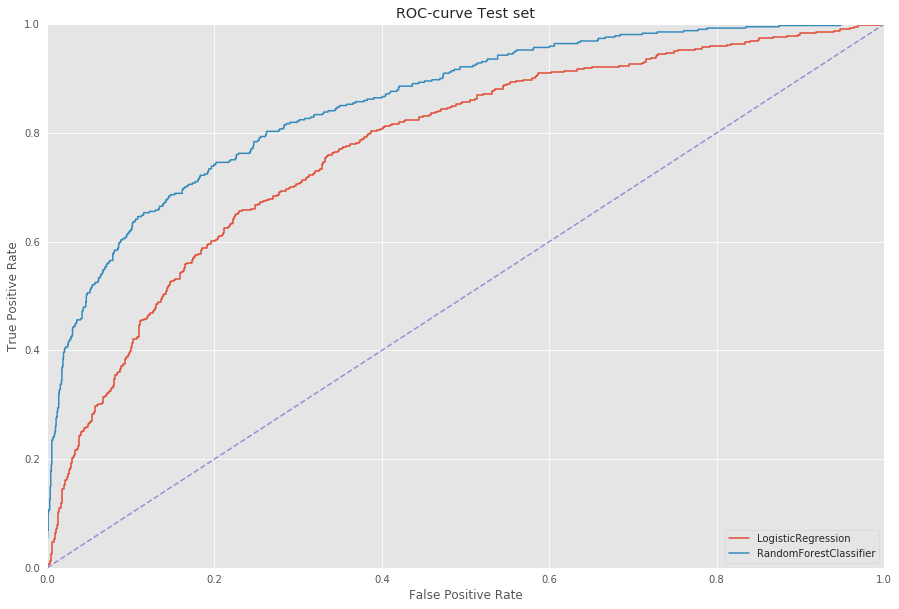

In [52]:
fig, ax = plt.subplots(figsize=(15, 10)) 

probabilities_test1 = model_lreg.predict_proba(features_test)
probabilities_one_test1 = probabilities_test1[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(target_test, probabilities_one_test1) 

probabilities_test = model_rfc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 


ax.plot(fpr1, tpr1, linestyle='-',label = 'LogisticRegression')
ax.plot(fpr, tpr, linestyle='-', label = 'RandomForestClassifier')
ax.legend(loc = 'lower right') 

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve Test set')

plt.show()

**Вывод:**  AUC  у RandomForestClassifier = 0.85, выше чем у LogisticRegression 0.77, что говорит о лучшей классификации.

### **Сравнение с константной моделью**

In [53]:
dummy = DummyClassifier(strategy='most_frequent').fit(pd.concat([features_train,features_valid]),pd.concat([target_train,target_valid]))
dummy_pred = dummy.predict(target_test)

print('Наиболее частотный класс: ', (np.unique(dummy_pred)))
# print('Accuracy score на тестовой выборке: ', accuracy_score(target_test, dummy_pred))

print(metrics.classification_report(target_test, dummy_pred ))

Наиболее частотный класс:  [0]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1579
           1       0.00      0.00      0.00       421

    accuracy                           0.79      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.62      0.79      0.70      2000



# **Вывод**

Налучшее показатели качества Accuracy и  F1 score показывает модель **RandomForestClassifier** и соответствует требованиям заказчика <br> 

In [54]:
table_of_models = (pd.DataFrame({'Model':table_of_model, 'Accuracy':table_of_acc, 
                                'F1 score':table_of_prec}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_of_models['Threshold of testing'] = (
                   table_of_models['F1 score'].apply(lambda x: 'Модель хороша' if x>0.59 else 'Модель плоховата')
)
table_of_models

,Model,Accuracy,F1 score,Threshold of testing
0,RandomForestClassifier,0.80,0.60,Модель хороша
1,LogisticRegression,0.72,0.51,Модель плоховата


Наибольшее значение имеет критерии
- возраст
- уровень
- заработной платы
- баланса. <br> 
Такие  показатели как пол, география проживания менее важные.

In [55]:
model_rfc.feature_importances_

array([0.05908387, 0.33484783, 0.03754329, 0.10086121, 0.2409398 ,
       0.00745549, 0.0604802 , 0.06380074, 0.01621395, 0.03684655,
       0.00954223, 0.0160062 , 0.01637864])

In [56]:
features_test.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'France', 'Germany', 'Spain',
       'Female', 'Male'],
      dtype='object')

In [57]:
fi = pd.DataFrame({'name':features_test.columns,'fi':model_rfc.feature_importances_})
fi.sort_values('fi',ascending=False)

,name,fi
1,age,0.33
4,numofproducts,0.24
3,balance,0.10
7,estimatedsalary,0.06
6,isactivemember,0.06
0,creditscore,0.06
2,tenure,0.04
9,Germany,0.04
12,Male,0.02
8,France,0.02


Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*